In [1]:
%matplotlib inline
import numpy as np
from numpy import genfromtxt

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

from scipy.interpolate import CubicSpline

In [2]:
data = genfromtxt('./walkCycles/walkCycle_0.0.csv',delimiter=',')
print(data[0,:].shape) # get length of dat

(196,)


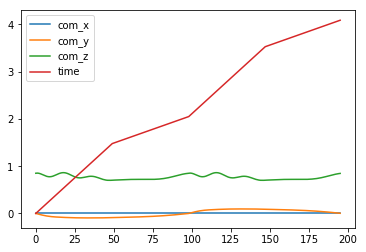

In [3]:
# plots of individual rows
fig = plt.figure()
ax = fig.add_subplot(111)

# graph com x,y,z
ax.plot(data[1,:],label='com_x')
ax.plot(data[2,:],label='com_y')
ax.plot(data[3,:],label='com_z')
# graph time
ax.plot(data[0,:],label='time')
ax.legend()

plt.show()

In [4]:
step_height = 0.1 # user can change this

# LEFT FOOT: find range, count of nans
l_idx_nan = np.where(np.isnan(data[4,:]))[0][0] # first nan value index
l_idx_after_nan = np.where(np.isnan(data[4,:]))[0][-1] + 1 # index right after last nan
left_nans = np.count_nonzero(np.isnan(data[5,:])) # count nans in left foot traj

print("Left nan range:  ({}, {}). Count: {}".format(l_idx_nan, l_idx_after_nan, left_nans))

# LEFT FOOT: touchdown points from data
left_initial = [ data[4, l_idx_nan - 1], data[5, l_idx_nan - 1], data[6, l_idx_nan - 1] ]
left_final = [ data[4,l_idx_after_nan], data[5,l_idx_after_nan], data[6,l_idx_after_nan] ]

# LEFT FOOT: peak between touchdowns
left_peak = [(left_initial[0] + left_final[0]) / 2, (left_initial[1] + left_final[1]) / 2, step_height]

print(left_initial)
print(left_peak)
print(left_final)

## Cubic Spline Interpolation

step_length = data[4,-1] - data[4,0]
# swing_steplen = step_length / left_nans # this is the number of samples we need to fill in the nans
swing_steplen = left_nans
print(swing_steplen)

# LEFT FOOT: points to interpolate over
l_x = [left_initial[0], left_peak[0], left_final[0]]
l_y = [left_initial[1], left_peak[1], left_final[1]]
l_z = [left_initial[2], left_peak[2], left_final[2]]

# generate cubic spline (only using left foot for simplicity and to enforce symmetry)
l_cs = CubicSpline(l_x, [l_y, l_z], axis=1)

# indices for cubic spline 
l_xs = np.linspace(l_x[0], l_x[2], num=swing_steplen)

Left nan range:  (98, 147). Count: 49
[2.0893e-62, -0.1, 0.0]
[2.805165e-61, -0.1, 0.1]
[5.4014e-61, -0.1, 0.0]
49


/home/drl/.local/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:590: LinAlgWarning: Ill-conditioned matrix (rcond=8.65412e-62): result may not be accurate.
  check_finite=False)


In [5]:
# RIGHT FOOT: find range, count of nans
r_idx_nan = np.where(np.isnan(data[8,:]))[0][0] # first nan value index
r_idx_after_nan = np.where(np.isnan(data[8,:]))[0][-1] + 1 # index right after last nan
right_nans = np.count_nonzero(np.isnan(data[8,:])) # count nans in right foot traj

print("Right nan range: ({}, {}). Count: {}".format(r_idx_nan, r_idx_after_nan, right_nans))


# RIGHT FOOT: invisible touchdown point before data
right_initial = [ data[7,r_idx_after_nan] - step_length, data[8,r_idx_after_nan], data[9,r_idx_after_nan] ]

# RIGHT FOOT: touchdown point from data
right_final = [ data[7,r_idx_after_nan], data[8,r_idx_after_nan], data[9,r_idx_after_nan] ]

# RIGHT FOOT: peak before touch down
right_peak_1 = [(right_final[0] - right_initial[0]) / 2, right_final[1], step_height]

print(right_initial)
print(right_peak_1)
print(right_final)

## Cubic Spline Interpolation

# RIGHT FOOT: points to interpolate over
r_x = [right_initial[0], right_peak_1[0], right_final[0]]
r_y = [right_initial[1], right_peak_1[1], right_final[1]]
r_z = [right_initial[2], right_peak_1[2], right_final[2]]

Right nan range: (0, 49). Count: 49
[1.627653e-60, 0.1, 0.0]
[2.5962350000000006e-61, 0.1, 0.1]
[2.1469e-60, 0.1, 0.0]


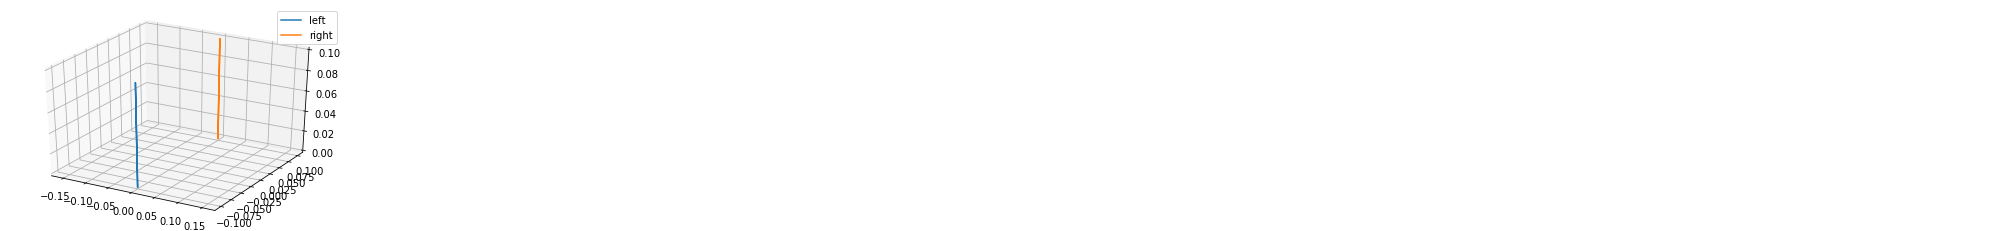

In [6]:
# plot cubic splines

left_spline = np.array([l_xs, l_cs(l_xs)[0], l_cs(l_xs)[1]])
spline_x_shift = step_length / 2
spline_y_shift = right_final[1] - left_final[1]
right_spline = np.array([left_spline[0] - spline_x_shift, left_spline[1] + spline_y_shift, left_spline[2]])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(left_spline[0], left_spline[1], left_spline[2], label='left')
ax.plot(right_spline[0], right_spline[1], right_spline[2], label='right')
ax.legend()
ax.axis('equal')
plt.show()

In [7]:
## Store data together

# COM: store straight from original data
com_data = np.array([data[1], data[2], data[3]])
print("COM full shape: {}\n".format(com_data.shape))

# LEFT FOOT: first from data, then from spline, then from data again
left_data = data[4:7, 0:l_idx_nan]
print("left inital shape: {}".format(left_data.shape))
left_data = np.hstack((left_data, left_spline) )
print("left_spline shape: {}".format(left_spline.shape))
left_data = np.hstack((left_data, data[4:7, l_idx_after_nan:]))
print("left final shape: {}".format(data[4:7, l_idx_after_nan:].shape))
print("left full shape: {}\n".format(left_data.shape))

# RIGHT FOOT: first from spline, then all from data
right_data = right_spline # same as left but shifted over half a period
print("right_spline shape: {}".format(right_spline.shape))
right_data = np.hstack((right_data, data[7:, r_idx_after_nan:]) )
print("right final shape: {}".format(data[7:, r_idx_after_nan:].shape))
print("right full shape: {}".format(right_data.shape))

COM full shape: (3, 196)

left inital shape: (3, 98)
left_spline shape: (3, 49)
left final shape: (3, 49)
left full shape: (3, 196)

right_spline shape: (3, 49)
right final shape: (3, 147)
right full shape: (3, 196)


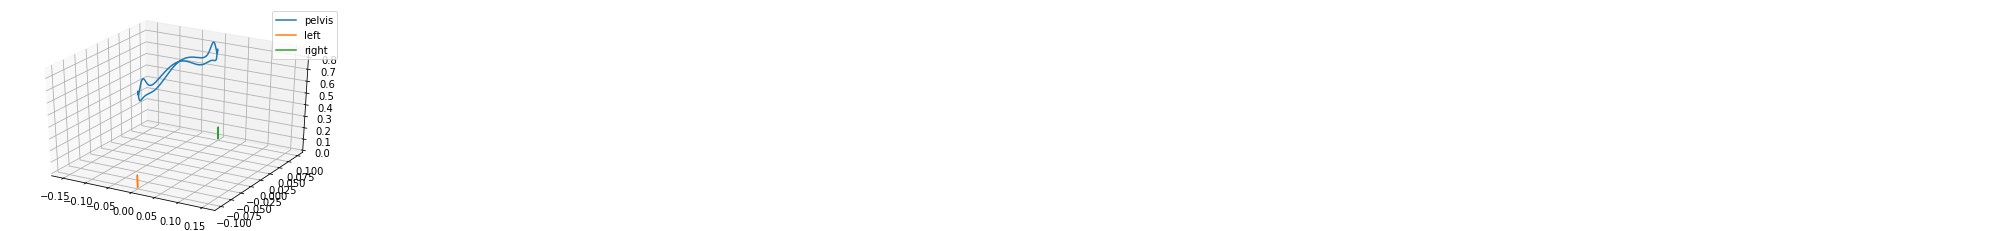

In [8]:
# It looks good! One final 3D plot...
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(com_data[0], com_data[1], com_data[2], label='pelvis')
ax.plot(left_data[0], left_data[1], left_data[2], label='left')
ax.plot(right_data[0], right_data[1], right_data[2], label='right')
ax.legend()
ax.axis('equal')
plt.show()

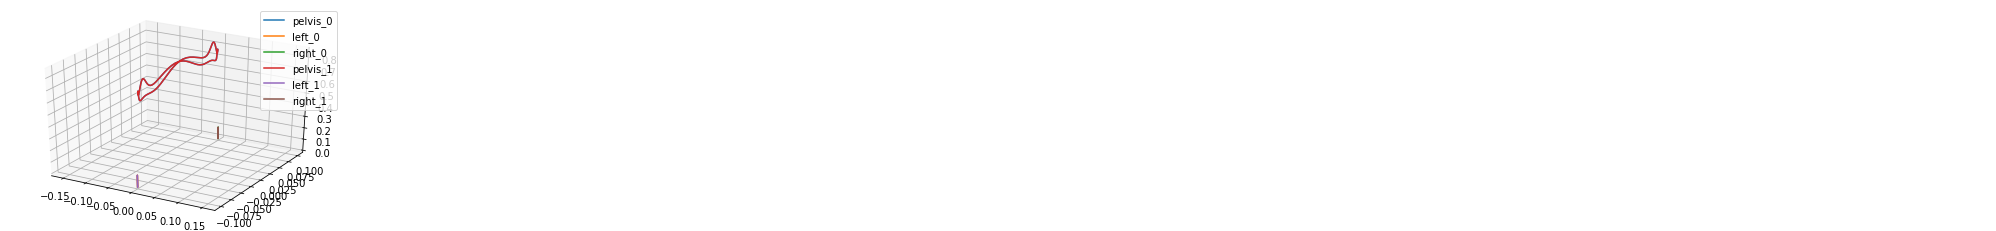

In [9]:
# plot of multiple cycles stiched together
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(2):
    offset = i * step_length
    ax.plot(com_data[0] + offset, com_data[1], com_data[2], label='pelvis_{}'.format(i))
    ax.plot(left_data[0] + offset, left_data[1], left_data[2], label='left_{}'.format(i))
    ax.plot(right_data[0] + offset, right_data[1], right_data[2], label='right_{}'.format(i))
ax.legend()
ax.axis('equal')
plt.show()

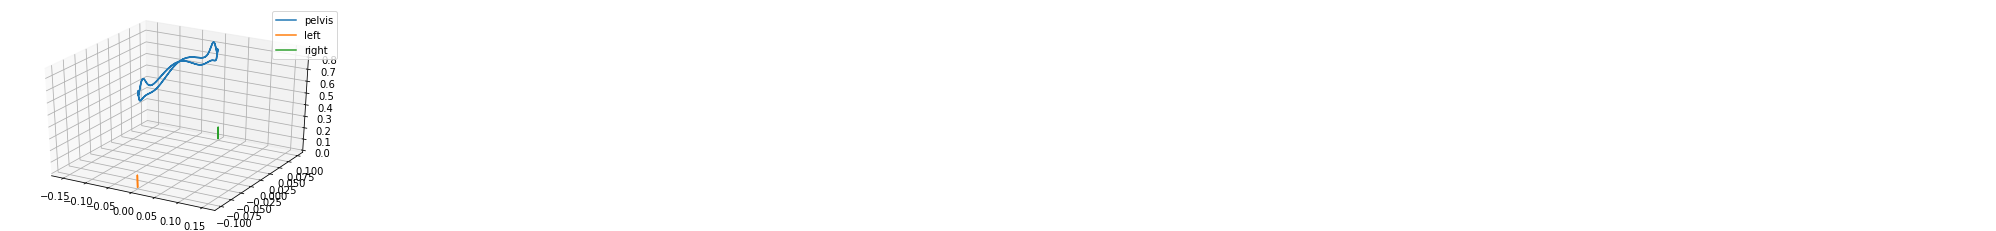

In [10]:
## Store data with added offset
# COM:
new_com_x = np.hstack((com_data[0], com_data[0] + step_length))
new_com_y = np.hstack((com_data[1], com_data[1]))
new_com_z = np.hstack((com_data[2], com_data[2]))
new_com = np.vstack((new_com_x, new_com_y, new_com_z))

# LEFT FOOT:
new_left_x = np.hstack((left_data[0], left_data[0] + step_length))
new_left_y = np.hstack((left_data[1], left_data[1]))
new_left_z = np.hstack((left_data[2], left_data[2]))
new_left = np.vstack((new_left_x, new_left_y, new_left_z))

# RIGHT FOOT:
new_right_x = np.hstack((right_data[0], right_data[0] + step_length))
new_right_y = np.hstack((right_data[1], right_data[1]))
new_right_z = np.hstack((right_data[2], right_data[2]))
new_right = np.vstack((new_right_x, new_right_y, new_right_z))

# plot of multiple cycles stiched together
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(new_com[0], new_com[1], new_com[2], label='pelvis')
ax.plot(new_left[0], new_left[1], new_left[2], label='left')
ax.plot(new_right[0], new_right[1], new_right[2], label='right')

ax.legend()
ax.axis('equal')
plt.show()

(3, 392)
(3, 392)
(3, 392)


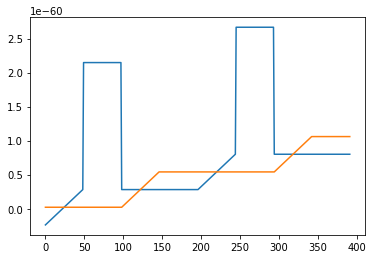

No handles with labels found to put in legend.


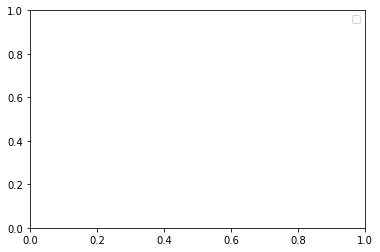

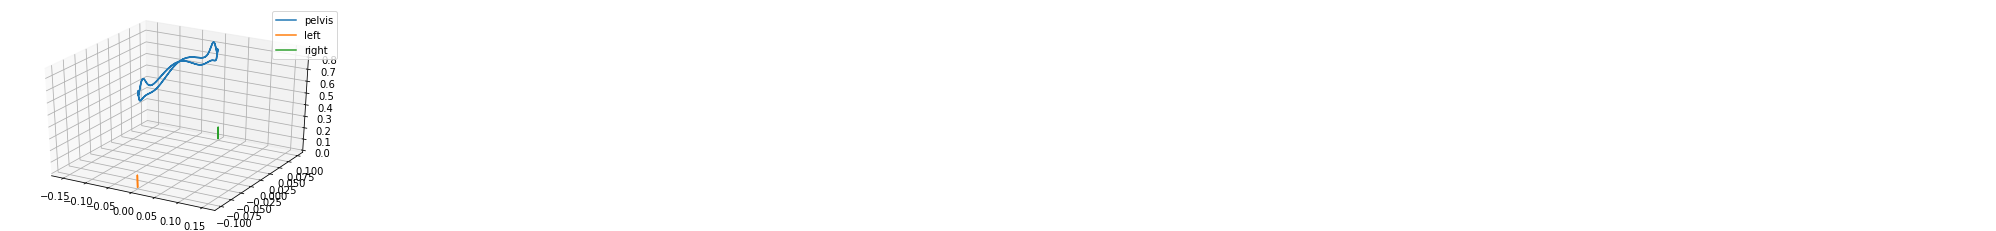

In [11]:
# Check for stepping motion
print(new_com.shape)
print(new_left.shape)
print(new_right.shape)

# plots of 3D data
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(new_left.shape[1]), new_right[0], label='right')
ax.plot(np.arange(new_left.shape[1]), new_left[0], label='left')
plt.show()
plt.legend()


# It looks good! One final 3D plot...
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(new_com[0], new_com[1], new_com[2], label='pelvis')
ax.plot(new_left[0], new_left[1], new_left[2], label='left')
ax.plot(new_right[0], new_right[1], new_right[2], label='right')
ax.legend()
ax.axis('equal')
plt.show()

In [12]:
# Stack data together (last element is the time)

new_time = np.hstack((data[0,:], data[0,:]))

print(new_right.shape)
print(new_left.shape)
print(new_com.shape)
print(new_time.shape)

output = np.vstack((new_right, new_left, new_com, new_time))
output.shape

# write to output file
np.save('./rom_processed/rom_traj_data.npy',output)

(3, 392)
(3, 392)
(3, 392)
(392,)
